# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Перший шар, який складається з 128 нейронів
        self.layer1 = DenseLayer(num_features, n_hidden_1)
        # Другий шар, який складається з 256 нейронів
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
        # Вихідний шар з 10 нейронами (кількість класів)
        self.out_layer = DenseLayer(n_hidden_2, num_classes)

    def __call__(self, x):
        # Передача даних через перші два шари та вихідний шар з функцією активації softmax
        x = self.layer1(x, activation=1)
        x = self.layer2(x, activation=1)
        x = self.out_layer(x, activation=1)

        return x

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Конвертуємо y_true в int64
    y_true = tf.cast(y_true, dtype=tf.int64)
    # Отримуємо індекси класів з найвищими ймовірностями
    predicted_classes = tf.argmax(y_pred, axis=1)
    # Порівнюємо передбачені класи з фактичними класами та обчислюємо точність
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted_classes, y_true), dtype=tf.float32))
    return accuracy

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
    # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
    optimizer = tf.optimizers.SGD(learning_rate)

    # Активація автоматичного диференціювання
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [7]:
# Тренування мережі
loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        # Обчислюємо поточну помилку
        loss = cross_entropy(pred, batch_y)
        loss_history.append(loss)
        
        # Обчислюємо поточну точність
        acc = accuracy(pred, batch_y)
        accuracy_history.append(acc)

        print(f"Step {step}, Loss: {loss}, Accuracy: {acc}")

Step 100, Loss: 588.17626953125, Accuracy: 0.109375
Step 200, Loss: 588.82177734375, Accuracy: 0.0859375
Step 300, Loss: 587.2200927734375, Accuracy: 0.06640625
Step 400, Loss: 584.6458740234375, Accuracy: 0.1328125
Step 500, Loss: 585.1981201171875, Accuracy: 0.16796875
Step 600, Loss: 583.5820922851562, Accuracy: 0.08984375
Step 700, Loss: 581.2745971679688, Accuracy: 0.1953125
Step 800, Loss: 577.23828125, Accuracy: 0.23046875
Step 900, Loss: 577.7081298828125, Accuracy: 0.19921875
Step 1000, Loss: 572.7025146484375, Accuracy: 0.23828125
Step 1100, Loss: 573.7427978515625, Accuracy: 0.23046875
Step 1200, Loss: 570.7254028320312, Accuracy: 0.26171875
Step 1300, Loss: 566.6773071289062, Accuracy: 0.27734375
Step 1400, Loss: 565.1233520507812, Accuracy: 0.26953125
Step 1500, Loss: 555.6065673828125, Accuracy: 0.3046875
Step 1600, Loss: 531.8626098632812, Accuracy: 0.3359375
Step 1700, Loss: 513.1361694335938, Accuracy: 0.35546875
Step 1800, Loss: 490.0711364746094, Accuracy: 0.36328125

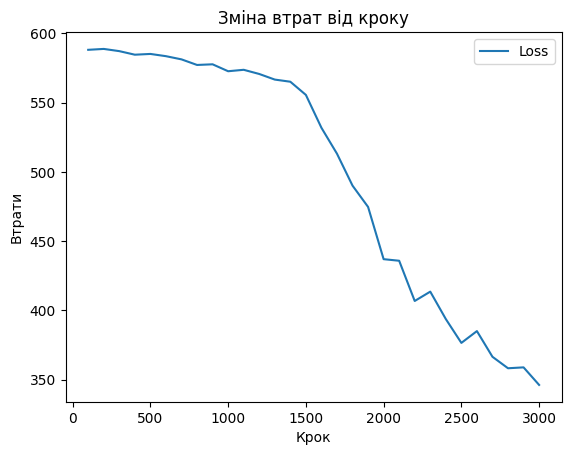

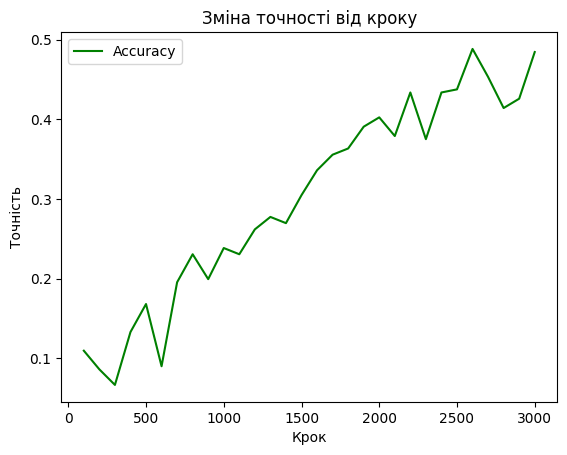

In [8]:
# Виведення графіку функції втрат
plt.plot(range(display_step, training_steps + 1, display_step), loss_history, label='Loss')
plt.title('Зміна втрат від кроку')
plt.xlabel('Крок')
plt.ylabel('Втрати')
plt.legend()
plt.show()

# Виведення графіку точності
plt.plot(range(display_step, training_steps + 1, display_step), accuracy_history, label='Accuracy', color='green')
plt.title('Зміна точності від кроку')
plt.xlabel('Крок')
plt.ylabel('Точність')
plt.legend()
plt.show()

In [9]:
# Обчислення точності навченої нейромережі
test_pred = neural_net(x_test)
test_accuracy = accuracy(test_pred, y_test)
print(f"Точність навченої нейромережі на тестових даних: {test_accuracy.numpy()}")

# Тестування моделі на тестових даних
test_loss = cross_entropy(test_pred, y_test)
print(f"Втрати навченої нейромережі на тестових даних: {test_loss.numpy()}")

Точність навченої нейромережі на тестових даних: 0.47200000286102295
Втрати навченої нейромережі на тестових даних: 13295.5732421875


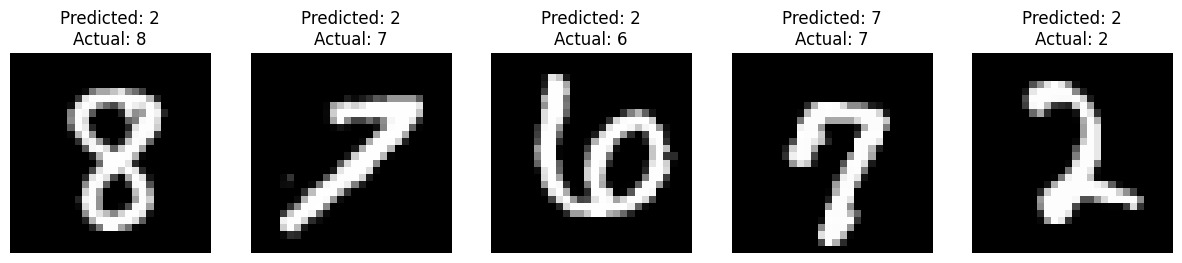

In [10]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Випадковий вибір 5 зображень з тестової вибірки
random_indices = np.random.choice(x_test.shape[0], size=5, replace=False)
images = x_test[random_indices]
labels = y_test[random_indices]

# Передача зображень через нейромережу та отримання передбачень
predictions = neural_net(images)

# Виведення зображень та передбачень
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Predicted: {np.argmax(predictions[i])}\nActual: {labels[i]}")
    plt.axis('off')
plt.show()





In [11]:
#  метрики якості для кожного класу навченої моделі
y_pred = neural_net(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.51      0.93      0.66       980
           1       0.94      0.91      0.93      1135
           2       0.39      0.67      0.49      1032
           3       0.51      0.79      0.62      1010
           4       0.38      0.07      0.12       982
           5       0.42      0.18      0.25       892
           6       0.31      0.08      0.13       958
           7       0.34      0.89      0.49      1028
           8       0.25      0.06      0.09       974
           9       0.38      0.00      0.01      1009

    accuracy                           0.47     10000
   macro avg       0.44      0.46      0.38     10000
weighted avg       0.45      0.47      0.39     10000



In [13]:
Нейронна мережа допускає помилки, помилки відбуваються достатньо часто, що вказує на необхідність подальшої оптимізації 
моделі. Загальна точність на рівні 40%, з чого можна зробити висновок, що більшу частину розпізнає невірно.